In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn as nn
from torch.optim import AdamW
import functions_text_model as functions

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we have to load the datasets, which have already been prepared in `data_labelling_json.ipynb`. The different datasets are:
- mixed_data_enriched: all utterances for which the speaker gender has been identified, augmented in order to be balanced.
- F_data: all utterances in which the speaker is a woman.
- M_data_enriched: all utterances in which the speaker is a man, augmented in order to be balanced.

In [2]:
# Load the data from the JSON files
with open('data/mixed_data.json') as file:
    mixed_data = json.load(file)

with open('data/F_data.json') as file:
    F_data = json.load(file)

with open('data/M_data.json') as file:
    M_data = json.load(file)

with open('data/mixed_data_enriched.json') as file:
    mixed_data_enriched = json.load(file)

with open('data/M_data_enriched.json') as file:
    M_data_enriched = json.load(file)

# Convert the data to lists of dictionaries
mixed_data = list(mixed_data.values())
F_data = list(F_data.values())
M_data = list(M_data.values())
mixed_data_enriched = list(mixed_data_enriched.values())
M_data_enriched = list(M_data_enriched.values())

Let's define some classes and functions needed in the training pipeline.

In [3]:
# Class for the PyTorch sarcasm detection Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        context = item['context']
        utterance_and_context = ' '.join([sentence for sentence in context] + [utterance]) # Combining the utterance and its context into one string.
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance_and_context)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

We will now train 3 different models: 
- one model will be trained on the mixed augmented data (mixed_data_enriched)
- one model will be trained on utterances from female speakers only (F_data)
- one model will be trained on utterances from male speakers only (M_data_enriched)

train Loss: 0.1947,  ACC: 0.9548, F1-weighted: 0.9544


100%|██████████| 2/2 [00:00<00:00, 12.05it/s]


eval Loss: 0.8347,  ACC: 0.6160, F1-weighted: 0.5982


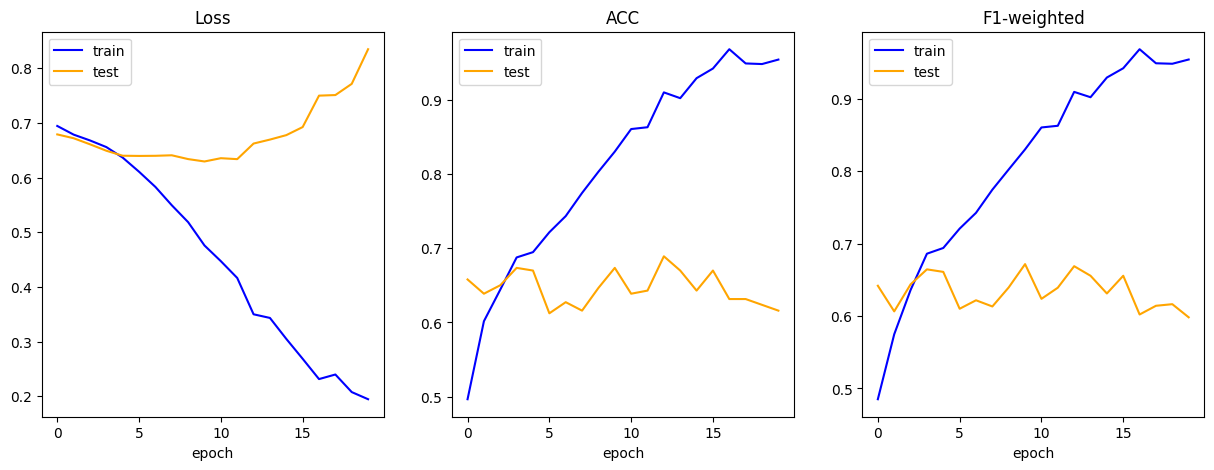

train loss [0.6943811376889547, 0.6785639524459839, 0.6679036418596903, 0.6557743748029073, 0.6364949842294058, 0.610649844010671, 0.5828645626703898, 0.5493872662385305, 0.5184729049603144, 0.47580960889657337, 0.4471183568239212, 0.41645167271296185, 0.3499689946571986, 0.34332435329755145, 0.3050021330515544, 0.2686222270131111, 0.23149282236893973, 0.23986207445462546, 0.20773071547349295, 0.19466802974541983] test loss [0.6789345145225525, 0.6719387769699097, 0.6608452796936035, 0.6490586698055267, 0.6399501264095306, 0.6395756602287292, 0.6398122608661652, 0.6407502293586731, 0.6337889134883881, 0.6294384300708771, 0.6354270577430725, 0.6336931586265564, 0.6622086763381958, 0.6694628596305847, 0.6775989234447479, 0.6923455595970154, 0.7498154044151306, 0.7508880496025085, 0.7713676691055298, 0.8347053527832031]


In [11]:
# MIXED MODEL ENRICHED

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(mixed_data_enriched)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
mixed_model_enriched = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

mixed_model_enriched.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

mixed_model_enriched.to(device)

# Define optimizer and criterion
optimizer = AdamW(mixed_model_enriched.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(mixed_model_enriched, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(mixed_model_enriched, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(mixed_model_enriched.state_dict(), 'models/mixed_model_text.pth')

train Loss: 0.3797,  ACC: 0.9589, F1-weighted: 0.9589


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


eval Loss: 0.5104,  ACC: 0.8049, F1-weighted: 0.7990


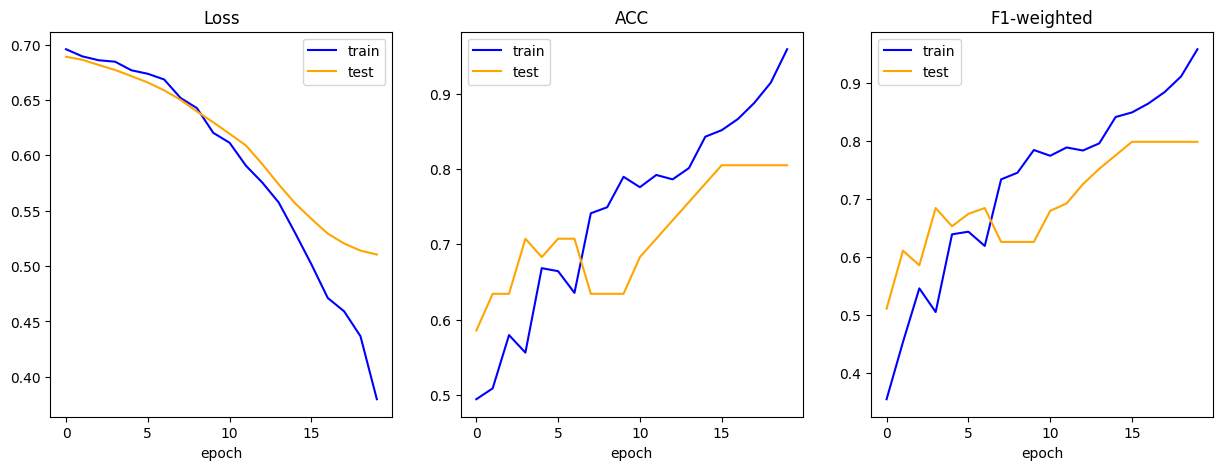

train loss [0.6958693265914917, 0.6894004543622335, 0.6859013636906942, 0.6845990816752116, 0.6768299341201782, 0.6736829876899719, 0.6685337821642557, 0.6518526275952657, 0.6427005926767985, 0.6203591028849283, 0.6113781332969666, 0.5906205375989279, 0.5754115184148153, 0.557459274927775, 0.5300479133923849, 0.5015910963217417, 0.4711941679318746, 0.4591113229592641, 0.4366101622581482, 0.3797213037808736] test loss [0.6890463829040527, 0.6863362193107605, 0.6816313862800598, 0.6771619915962219, 0.6715592741966248, 0.6657997965812683, 0.6587570905685425, 0.6501685380935669, 0.6396948099136353, 0.629843533039093, 0.619518518447876, 0.6089212894439697, 0.5920049548149109, 0.573814332485199, 0.5567286014556885, 0.5426257848739624, 0.5293263792991638, 0.5203773975372314, 0.5139438509941101, 0.5104076862335205]


In [6]:
# FEMALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(F_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
F_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

F_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

F_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(F_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(F_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(F_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(F_model.state_dict(), 'models/F_model_text.pth')

train Loss: 0.2130,  ACC: 0.9670, F1-weighted: 0.9666


100%|██████████| 2/2 [00:00<00:00, 15.09it/s]


eval Loss: 0.8007,  ACC: 0.6202, F1-weighted: 0.5971


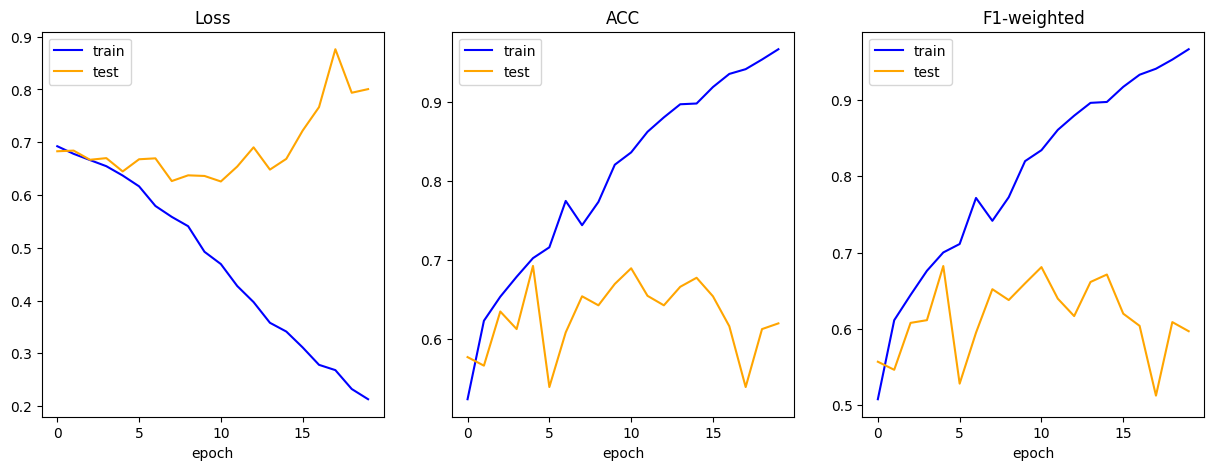

train loss [0.692457894484202, 0.6780351797739664, 0.6662590603033701, 0.6546032627423605, 0.63690714041392, 0.6164625883102417, 0.5792491485675176, 0.5585536658763885, 0.5408937980731329, 0.4923905630906423, 0.46916282673676807, 0.4276219407717387, 0.3971136311690013, 0.35788479447364807, 0.34127895534038544, 0.31120313704013824, 0.2782143826285998, 0.2681744694709778, 0.23241718858480453, 0.21304681400458017] test loss [0.6828970611095428, 0.6841448843479156, 0.6667748689651489, 0.6698931455612183, 0.6446919739246368, 0.6677343845367432, 0.6695036292076111, 0.6264569461345673, 0.6372987329959869, 0.636120617389679, 0.625661164522171, 0.6539229154586792, 0.6903767883777618, 0.6481676697731018, 0.6684948205947876, 0.7220369875431061, 0.7665290236473083, 0.8762639462947845, 0.7937799394130707, 0.8006727397441864]


In [10]:
# MALE MODEL ENRICHED

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(M_data_enriched)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
M_model_enriched = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

M_model_enriched.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

M_model_enriched.to(device)

# Define optimizer and criterion
optimizer = AdamW(M_model_enriched.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(M_model_enriched, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(M_model_enriched, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(M_model_enriched.state_dict(), 'models/M_model_text.pth')